In [1]:
import os
import shutil
import glob
import numpy as np
import math
import re
import random
from PIL import Image
import matplotlib.pyplot as plt
from skimage import feature
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from skimage import filters 
import cv2
from sklearn import manifold
from matplotlib import cm

# Data Preparation

### Images Sampling

Steps:
* sample from 38 category (species x condition) by a fixed rate
    - random draw without replacement
* split train-valid-valid dataset
* integrate images into 14 categories (by species)


Dataset size: xxxxx (to be updated)

In [14]:
### sample images from folder (ONLY RUN ONCE)
# before running, delete everything in the dst_dir

os.getcwd()
os.chdir("/Users/catherineyu/Plant")

sample_pct = np.array([0.05, 0.03, 0.02])  # train/validation/valid
src_dir = "/Users/catherineyu/Plant/Plant_dataset"
dst_dir = "/Users/catherineyu/Plant/Plant_dataset_sampled"

# create path
train_dir = os.path.join(dst_dir, "train")
valid_dir = os.path.join(dst_dir, "valid")
test_dir = os.path.join(dst_dir, "test")
os.makedirs(train_dir)
os.makedirs(valid_dir)
os.makedirs(test_dir)

# define category list
category_list = os.listdir(src_dir)
category_list.remove(".DS_Store")
category_list.remove("Background_without_leaves")
category_list.sort()

for cat in category_list:
    
    # create path
    src_cat_dir = os.path.join(src_dir, cat)
    train_cat_dir = os.path.join(train_dir, cat)
    valid_cat_dir = os.path.join(valid_dir, cat)
    test_cat_dir = os.path.join(test_dir, cat)
    os.makedirs(train_cat_dir)
    os.makedirs(valid_cat_dir)
    os.makedirs(test_cat_dir)   

    # determine sample counts
    total_cnt = len(os.listdir(src_cat_dir))
    sample_cnt = [math.floor(i) for i in sample_pct * total_cnt]
    print(cat, "sampled count:", sample_cnt)

    # random draw without replacement
    random.seed(1)
    total_im_list = list(range(1, total_cnt))
    sample_im_list = random.sample(total_im_list, sum(sample_cnt))

    # copy images
    train_cnt, valid_cnt, test_cnt = sample_cnt[0], sample_cnt[1], sample_cnt[2]
    for im in sample_im_list[0:train_cnt]:
        img_name = 'image ({}).JPG'.format(im)
        shutil.copy(os.path.join(src_dir, cat, img_name), train_cat_dir)
    
    for im in sample_im_list[train_cnt:(train_cnt+valid_cnt)]:
        img_name = 'image ({}).JPG'.format(im)
        shutil.copy(os.path.join(src_dir, cat, img_name), valid_cat_dir)
    
    for im in sample_im_list[(train_cnt+valid_cnt):]:
        img_name = 'image ({}).JPG'.format(im)
        shutil.copy(os.path.join(src_dir, cat, img_name), test_cat_dir)

Apple___Apple_scab sampled count: [31, 18, 12]
Apple___Black_rot sampled count: [31, 18, 12]
Apple___Cedar_apple_rust sampled count: [13, 8, 5]
Apple___healthy sampled count: [82, 49, 32]
Blueberry___healthy sampled count: [75, 45, 30]
Cherry___Powdery_mildew sampled count: [52, 31, 21]
Cherry___healthy sampled count: [42, 25, 17]
Corn___Cercospora_leaf_spot Gray_leaf_spot sampled count: [25, 15, 10]
Corn___Common_rust sampled count: [59, 35, 23]
Corn___Northern_Leaf_Blight sampled count: [49, 29, 19]
Corn___healthy sampled count: [58, 34, 23]
Grape___Black_rot sampled count: [59, 35, 23]
Grape___Esca_(Black_Measles) sampled count: [69, 41, 27]
Grape___Leaf_blight_(Isariopsis_Leaf_Spot) sampled count: [53, 32, 21]
Grape___healthy sampled count: [21, 12, 8]
Orange___Haunglongbing_(Citrus_greening) sampled count: [275, 165, 110]
Peach___Bacterial_spot sampled count: [114, 68, 45]
Peach___healthy sampled count: [18, 10, 7]
Pepper,_bell___Bacterial_spot sampled count: [49, 29, 19]
Pepper,_

In [16]:
# --- init path settings ---

src_dir = "/Users/catherineyu/Plant/Plant_dataset"
dst_dir = "/Users/catherineyu/Plant/Plant_dataset_sampled"
train_dir = os.path.join(dst_dir, "train")
valid_dir = os.path.join(dst_dir, "valid")
test_dir = os.path.join(dst_dir, "test")

# define category list
category_list = os.listdir(src_dir)
category_list.remove(".DS_Store")
category_list.remove("Background_without_leaves")
category_list.sort()


# --- Helper Functions and global objects ---

# a shorter list of category 
temp_category_list = [
        'Apple___Apple_scab', 'Apple___healthy', 
        'Blueberry___healthy', 
        'Cherry___Powdery_mildew', 'Cherry___healthy',
        'Corn___Northern_Leaf_Blight', 'Corn___healthy', 
        'Grape___Esca_(Black_Measles)', 'Grape___healthy', 
        'Orange___Haunglongbing_(Citrus_greening)', 
        'Peach___Bacterial_spot', 'Peach___healthy', 
        'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 
        'Potato___Late_blight', 'Potato___healthy', 
        'Raspberry___healthy', 
        'Soybean___healthy', 
        'Squash___Powdery_mildew', 
        'Strawberry___Leaf_scorch', 'Strawberry___healthy', 
        'Tomato___Septoria_leaf_spot', 'Tomato___healthy'
    ]

def load_image_from_folder(dataset):
    """
    Return images and labels under certain folder as numpy arrays.
    `dataset`: train / valid / test
    """
    images = []
    labels = []
    ds_dir = os.path.join(dst_dir, dataset)

    for cat in temp_category_list:
        ds_cat_dir = os.path.join(ds_dir, cat)
        
        # load images
        images_cat = []
        for im_name in glob.glob(ds_cat_dir+'/*.JPG'):
            im = Image.open(im_name) 
            im = im.resize((256, 256)) # 90% images in our dataset are size (256, 256)
            # im = plt.imread(im_name)
            images_cat.append(im)

        # read labels
        labels_cat = [cat] * len(images_cat)
    
        images.extend(images_cat)
        labels.extend(labels_cat)

    return images, labels

<class 'PIL.Image.Image'>
Apple___Apple_scab
Apple


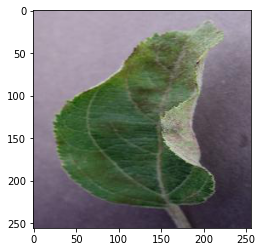

In [17]:
# --- load data ---

# read images(X), labels (Y) and create object
images_train, labels_train = load_image_from_folder("train")
images_valid, labels_valid = load_image_from_folder("valid")
images_test, labels_test = load_image_from_folder("test")

# integrate labels to 14 categories
labels_train_14 = [re.split(r'([_|,])', i)[0] for i in labels_train]
labels_valid_14 = [re.split(r'([_|,])', i)[0] for i in labels_valid]
labels_test_14 = [re.split(r'([_|,])', i)[0] for i in labels_test]

# sanity check
print(type(images_train[0]))
print(labels_train[0])
print(labels_train_14[0])
plt.imshow(images_train[0])

**(version I)**
The images are currently stored using `Pillow (PIL)`. 
If it doesn't work with `np.array` multiplications, 
1. use `np.asarray` to change the data type before multiplication, OR
2. re-load all images with `plt.imread`

**(version II)**
Images are stored in `np.array` format.

Several ways to load image data (different libraries, data types):
https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays

# Feature Extraction

In [25]:
# --- Helper functions ---

def turn_greyscale(image_list):
    """
    Output a array with all the images turns into grayscale. Shape of the output is fixed at (n * 256 * 256).
    """
    grey_img_array = []
    if type(image_list[0]) != type(np.empty(2)):
        for i in range(len(image_list)):
            grey_img_array.append(np.array(image_list[i].convert('L')))
    else:
        for i in range(len(image_list)):
            grey_img_array.append(np.mean(image_list[i], axis=2))
    return grey_img_array

def get_feature_edges(image_list): # edited
    """
    Output a array with all the grayscale images inside. Shape of the output is fixed at (n * 256 * 256).
    """
    images_train_arr_grey = turn_greyscale(image_list)
    n = len(images_train_arr_grey)
    output = np.empty((n, 256, 256))
    for i in range(n):
        output[i] = feature.canny(image=images_train_arr_grey[i], sigma=1, low_threshold=60, high_threshold=90).astype(np.int32)
    return output

def get_feature_sobel(image_list):
    """
    Output a array with all the grayscale images inside. Shape of the output is fixed at (n * 256 * 256).
    """
    images_train_arr_grey = turn_greyscale(image_list)
    n = len(images_train_arr_grey)
    output = np.empty((n, 256, 256))
    for i in range(n):
        output[i] = filters.sobel(images_train_arr_grey[i])
    return output

def get_feature_intensity(image_list):
    """
    Output a array with all the grayscale images inside. Shape of the output is fixed at (n * 256 * 256).
    """
    images_train_arr_grey = turn_greyscale(image_list)
    n = len(images_train_arr_grey)
    output = np.empty((n, 256, 256))
    for i in range(n):
        output[i] = np.where(images_train_arr_grey[i] < 85, 0, 255)
    return output

def get_feature_hessian(image_list):
    """
    Output 3 grayscale arrays from 3 channels. Shape of the output is fixed at (n * 256 * 256).
    """
    hessian_array = []
    for i in range(len(image_list)):
        H = hessian_matrix(image_list[i], sigma=0.1, order='rc')
        I = hessian_matrix_eigvals(H)
        hessian_array.append(I[0]*255)
    
    img_hessian_0 = [x[:,:,0] for x in hessian_array]
    # img_hessian_1 = [x[:,:,1] for x in hessian_array]
    # img_hessian_2 = [x[:,:,2] for x in hessian_array]

    return np.array(img_hessian_0) #, np.array(img_hessian_1), np.array(img_hessian_2)

def get_feature_cropped_hsv_histogram(dataset):
    """
    Output 3 histogram from 3 channels. Shape of the output is fixed at (3 * 256).
    """
    n = len(dataset)
    output = np.empty((n, 3, 256))
    for i in range(n):
        image = np.array(dataset[i])[78:178, 78:178]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        for channel_id in range(3):
            output[i, channel_id], _ = np.histogram(image[:, :, channel_id], bins=256, range=(0, 256))

    return output

def get_feature_cropped_rgb_histogram(dataset):
    """
    Output 3 histogram from 3 channels. Shape of the output is fixed at (3 * 256).
    """
    n = len(dataset)
    output = np.empty((n, 3, 256))
    for i in range(n):
        image = np.array(dataset[i])[78:178, 78:178]
        for channel_id in range(3):
            output[i, channel_id], _ = np.histogram(image[:, :, channel_id], bins=256, range=(0, 256))

    return output

def plot_color_histogram(image, label, color_space):
    """
    Create the histogram plot with three lines, one for each channel.
    Line color != Color channel.
    """
    fig, ax = plt.subplots(ncols=2, figsize=(8, 2))
    ax[0].imshow(image)
    # ax[1].xlim([0, 256])
    line_color = ["red", "green", "blue"]
    for channel_id in range(3):
        histogram, bin_edges = np.histogram(
            image[:, :, channel_id], bins=256, range=(0, 256)
        )
        ax[1].plot(bin_edges[0:-1], histogram, color=line_color[channel_id], label=color_space[channel_id])

    ax[1].set_title("Color Histogram - {}".format(label))
    ax[1].set(xlabel="Color value", ylabel="Pixel count")
    ax[1].legend(labels=color_space)

In [28]:
#feature extraction of training data

#edge
edges_train = get_feature_edges(images_train)
edges_flat_train = edges_train.reshape(edges_train.shape[0], 256*256) # (256 * 256): 2D canny image size

#rgb
rgb_train = get_feature_cropped_rgb_histogram(images_train)
rgb_flat_train = rgb_train.reshape(rgb_train.shape[0], 3*256) # (3 * 256): 3 channels * 256 histomgram bins

#hsv
hsv_train = get_feature_cropped_hsv_histogram(images_train)
hsv_flat_train = hsv_train.reshape(hsv_train.shape[0], 3*256) # (3 * 256): 3 channels * 256 histomgram bins

#sobel
sobel_train = get_feature_sobel(images_train)
sobel_flat_train = sobel_train.reshape(sobel_train.shape[0], 256*256)

#intensity
intensity_train = get_feature_intensity(images_train)
intensity_flat_train = intensity_train.reshape(intensity_train.shape[0], 256*256)

#hessian
hessian_train = get_feature_hessian(images_train)
hessian_flat_train = np.array(hessian_train).reshape(len(hessian_train), 256*256)

/opt/homebrew/Caskroom/miniforge/base/envs/aml/lib/python3.10/site-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


## Analysis & Visualization

**Edge & leaf vein features**
Observations:
1. Three methods are used to extract edges and veins - the Edges feature use the Canny filter to extract edges; the Hessian feature use a ridge filter by getthing the major eigenvalue of the Hessian matrix; the Sobel feature use a Sobel filter. 
2. From the images, it seems like the Hessian methods works best on eliminating the shaddows in the images, and also perform best in extracting the shape of the leaves. The Sobel methods works better on extracting the edges. Overall, the Hessian methods looks best, but the runtime is also the longest. 

**Intensity features**
Observations:
1. Looking at the original pictures, we notice that the surface of the leaves can be roughly classify by its light reflection rate. We try to get intensity features by filtering out grayscale values that are larger than the threshold(ex.85).
2. from the images below, leaf surface that reflects more light looks whiter, while leaf surface that reflects less light looks darker. 

**Color Space related features**

Observations:
1. From the plot, HSV (Hue-Saturation-Value) provides more variance between species compared to RGB. The outcome accuracy is also higher (trained in SVM Classifier).
2. In general, cropped image is a better starting point for colorspace feature extraction because the results are less influenced by background and leaf shadow.

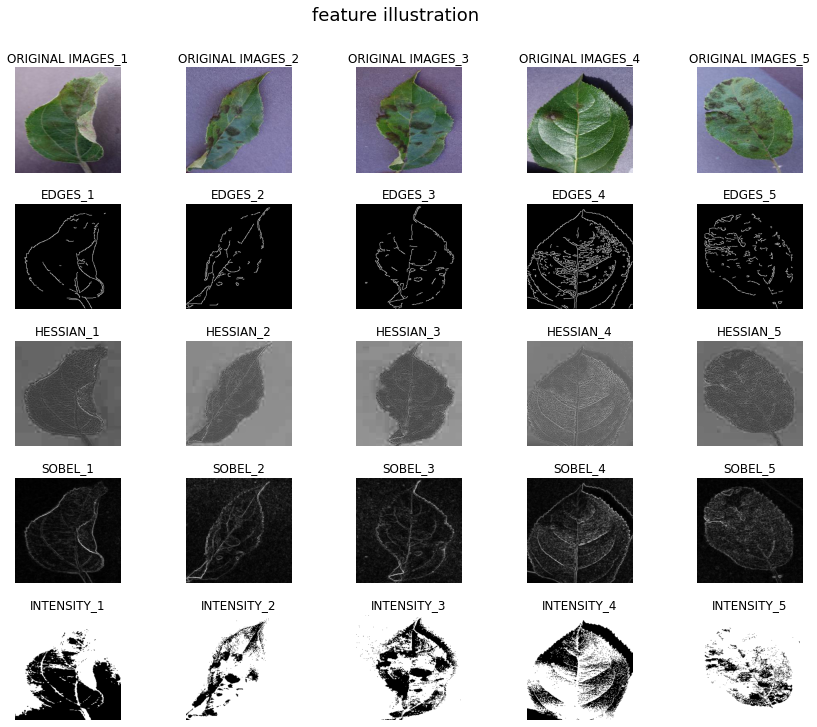

In [29]:
# --- 2D features ---
features = [images_train, edges_train, hessian_train, sobel_train, intensity_train]
feature_name = ['original images', 'edges', 'hessian', 'sobel', 'intensity']

## define subplot grid
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.1)
fig.suptitle("feature illustration", fontsize=18, y=0.95)

#ax[0,0].imshow(edges_train[0], cmap = 'gray')

for f in range(0,len(features)):
    for i in range(0,5):
        ax[f,i].imshow(features[f][i], cmap = 'gray')
        ax[f,i].axis('off')
        ax[f,i].set_title(feature_name[f].upper() + '_' + str(i+1))

plt.show()

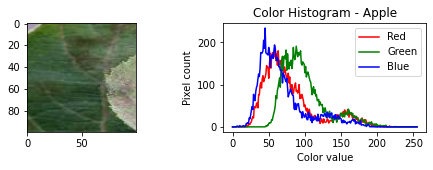

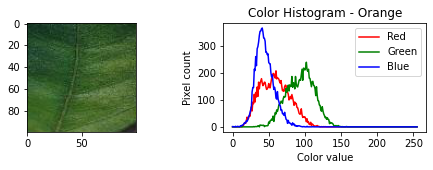

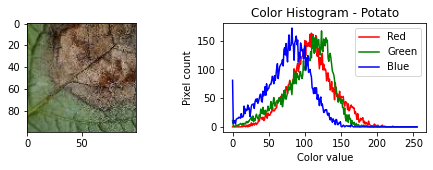

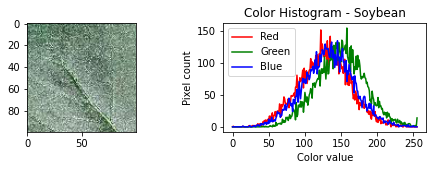

In [30]:
# --- histogram features ---

# cropped image
for i in [0, 741, 1014, 1115]:
    image = np.array(images_train[i])[78:178, 78:178] # crop the center of image
    label = labels_train_14[i]
    color_space = ["Red", "Green", "Blue"]
    plot_color_histogram(image, label, color_space)

**RGB**

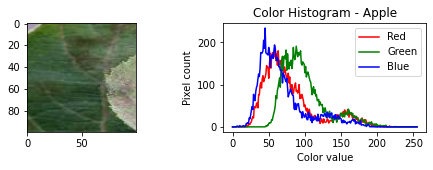

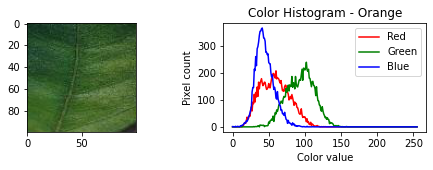

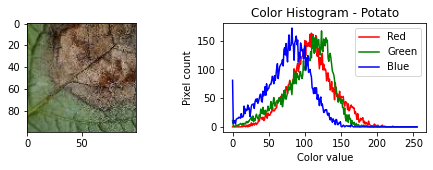

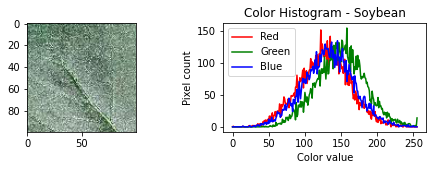

In [31]:
# cropped image
for i in [0, 741, 1014, 1115]:
    image = np.array(images_train[i])[78:178, 78:178] # crop the center of image
    label = labels_train_14[i]
    color_space = ["Red", "Green", "Blue"]
    plot_color_histogram(image, label, color_space)

**Reference**

Pillow library
* https://realpython.com/image-processing-with-the-python-pillow-library/

Colorspace
* https://medium.com/mlearning-ai/color-shape-and-texture-feature-extraction-using-opencv-cb1feb2dbd73



### Textures (SKIPPED FOR NOW)
[Local Binary Pattern for texture classification](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_local_binary_pattern.html)
* When using LBP to detect texture, you measure a collection of LBPs over an image patch and look at the distribution of these LBPs. Lets apply LBP to a brick texture.
* The histogram of the LBP result is a good measure to classify textures. Here, we test the histogram distributions against each other using the Kullback-Leibler-Divergence.


In [48]:
from skimage.feature import local_binary_pattern
from skimage.color import label2rgb


def get_center_LBP_analysis(image):
    """
    Return the local binary pattern (LBP) in the center part of the image.
    
    Input:
    `image` - image with only ONE channel and in `np.array` format.
    
    Return:
    `lbp` - 
    """

    # settings
    # 3, 8*r / 5, 24*r
    radius = 3 
    n_points = 8 * radius


    def overlay_labels(image, lbp, labels):
        mask = np.logical_or.reduce([lbp == each for each in labels])
        return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


    def highlight_bars(bars, indexes):
        for i in indexes:
            bars[i].set_facecolor('r')

    
    image = image[78:178, 78:178]
    lbp = local_binary_pattern(image, n_points, radius, 'uniform')


    def hist(ax, lbp):
        n_bins = int(lbp.max() + 1)
        return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                    facecolor='0.5')


    # plot histograms of LBP of textures
    fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
    plt.gray()

    titles = ('edge', 'flat', 'corner')
    w = width = radius - 1
    edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
    flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
    i_14 = n_points // 4            # 1/4th of the histogram
    i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
    corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                    list(range(i_34 - w, i_34 + w + 1)))

    label_sets = (edge_labels, flat_labels, corner_labels)

    for ax, labels in zip(ax_img, label_sets):
        ax.imshow(overlay_labels(image, lbp, labels))

    for ax, labels, name in zip(ax_hist, label_sets, titles):
        counts, _, bars = hist(ax, lbp)
        highlight_bars(bars, labels)
        ax.set_ylim(top=np.max(counts[:-1]))
        ax.set_xlim(right=n_points + 2)
        ax.set_title(name)

    ax_hist[0].set_ylabel('Percentage')
    for ax in ax_img:
        ax.axis('off')

    return lbp

def get_center_LBP(image):
    """
    Return the local binary pattern (LBP) in the center part of the image.
    
    Input:
    `image` - image with only ONE channel and in `np.array` format.
    
    Return:
    `lbp` - 
    """

    # settings
    # 3, 8*r / 5, 24*r
    radius = 3 
    n_points = 8 * radius

    def overlay_labels(image, lbp, labels):
        mask = np.logical_or.reduce([lbp == each for each in labels])
        return label2rgb(mask, image=image, bg_label=0, alpha=0.5)

    def highlight_bars(bars, indexes):
        for i in indexes:
            bars[i].set_facecolor('r')
    
    image = image[78:178, 78:178]
    lbp = local_binary_pattern(image, n_points, radius, 'uniform')

    return lbp

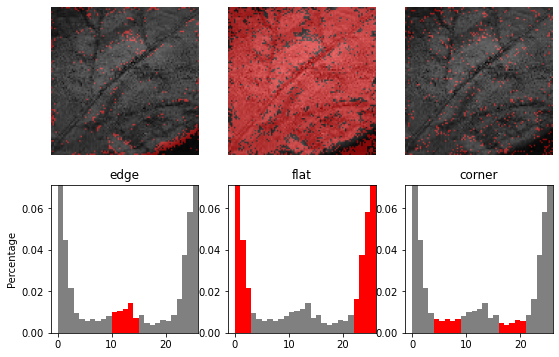

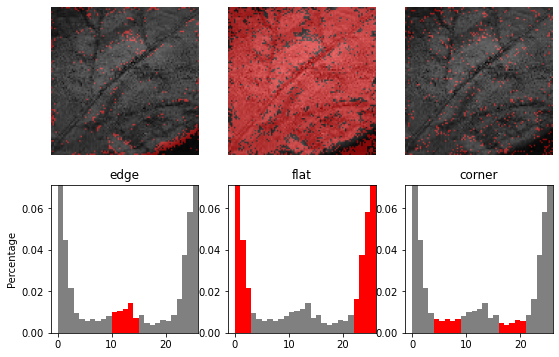

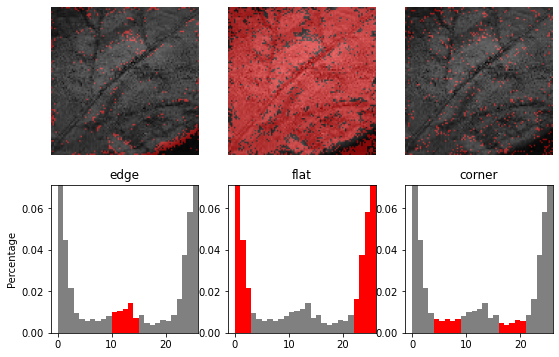

In [103]:
im_r = images_train[0][:,:,0]
lbp= get_center_LBP_analysis(im)

im_g = images_train[0][:,:,1]
lbp= get_center_LBP_analysis(im)

im_b = images_train[0][:,:,2]
lbp= get_center_LBP_analysis(im)

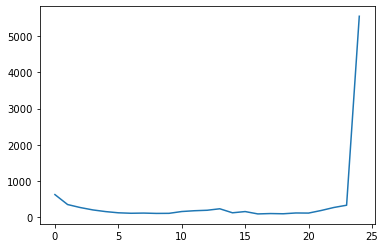

In [98]:
# plt.imshow(lbp)
histogram, bin_edges = np.histogram(lbp, bins=25)
plt.plot(bin_edges[0:-1], histogram) 

In [104]:
im_r, im_g

(array([[174, 175, 176, ..., 175, 177, 177],
        [175, 175, 176, ..., 175, 176, 176],
        [176, 176, 176, ..., 173, 174, 175],
        ...,
        [ 84,  84,  84, ...,  49,  48,  48],
        [ 83,  83,  83, ...,  49,  48,  48],
        [ 82,  82,  83, ...,  49,  49,  49]], dtype=uint8),
 array([[161, 162, 163, ..., 166, 168, 168],
        [162, 162, 163, ..., 166, 167, 167],
        [163, 163, 163, ..., 164, 165, 166],
        ...,
        [ 70,  70,  70, ...,  40,  39,  39],
        [ 69,  69,  69, ...,  40,  39,  39],
        [ 68,  68,  69, ...,  40,  40,  40]], dtype=uint8))

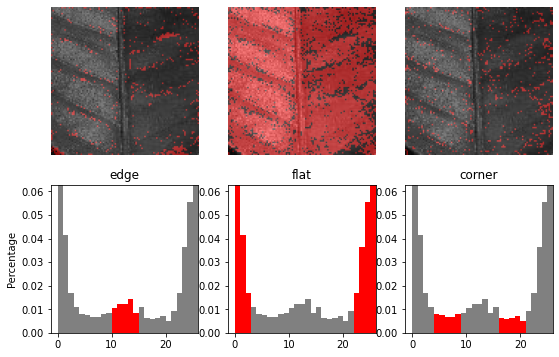

In [99]:
im = images_train[741][:,:,0]
lbp= get_center_LBP_analysis(im)

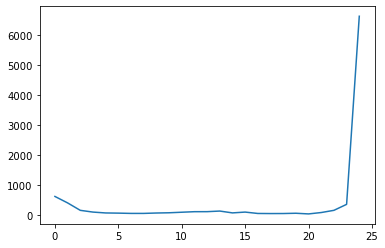

In [100]:
# plt.imshow(lbp)
histogram, bin_edges = np.histogram(lbp, bins=25)
plt.plot(bin_edges[0:-1], histogram) 

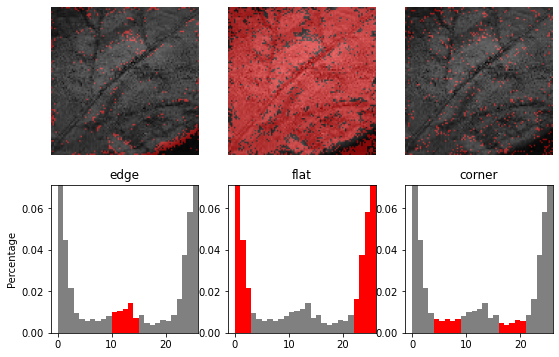

In [101]:
im = images_train[1115][:,:,0]
lbp= get_center_LBP_analysis(im)

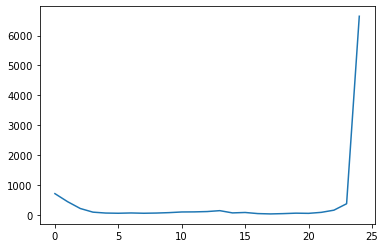

In [102]:
# plt.imshow(lbp)
histogram, bin_edges = np.histogram(lbp, bins=25)
plt.plot(bin_edges[0:-1], histogram) 

In [94]:
np.min(lbp), np.max(lbp)

(0.0, 25.0)

In [95]:
histogram, bin_edges = np.histogram(lbp, bins=25)
plt.plot(bin_edges[0:-1], histogram) 

In [96]:
bin_edges

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.])

Potato


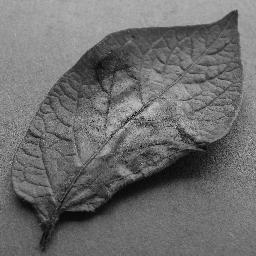

In [210]:
print(labels_train_14[1115])
im = images_train[1115].convert("L") # convert to grayscale
im

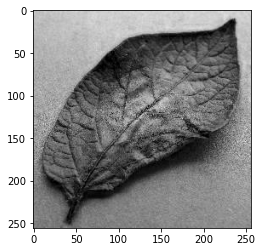

In [208]:
# plt.imshow(np.asarray(im)[:, :, 0])
# plt.imshow(np.asarray(im)[:, :, 1])
plt.imshow(np.asarray(im)[:, :, 2])

In [127]:
np.array(images_train[0]) * 0.1

array([[[17.4, 16.1, 17.8],
        [17.5, 16.2, 17.9],
        [17.6, 16.3, 18. ],
        ...,
        [17.5, 16.6, 18.3],
        [17.7, 16.8, 18.5],
        [17.7, 16.8, 18.5]],

       [[17.5, 16.2, 17.9],
        [17.5, 16.2, 17.9],
        [17.6, 16.3, 18. ],
        ...,
        [17.5, 16.6, 18.3],
        [17.6, 16.7, 18.4],
        [17.6, 16.7, 18.4]],

       [[17.6, 16.3, 18. ],
        [17.6, 16.3, 18. ],
        [17.6, 16.3, 18. ],
        ...,
        [17.3, 16.4, 18.1],
        [17.4, 16.5, 18.2],
        [17.5, 16.6, 18.3]],

       ...,

       [[ 8.4,  7. ,  9.3],
        [ 8.4,  7. ,  9.3],
        [ 8.4,  7. ,  9.3],
        ...,
        [ 4.9,  4. ,  5.9],
        [ 4.8,  3.9,  5.8],
        [ 4.8,  3.9,  5.8]],

       [[ 8.3,  6.9,  9.2],
        [ 8.3,  6.9,  9.2],
        [ 8.3,  6.9,  9.2],
        ...,
        [ 4.9,  4. ,  5.9],
        [ 4.8,  3.9,  5.8],
        [ 4.8,  3.9,  5.8]],

       [[ 8.2,  6.8,  9.1],
        [ 8.2,  6.8,  9.1],
        [ 8.3,  

### Feature Pipeline

In [40]:
## feature extraction for validation and testing data

#VALIDATION DATA
#edge
edges_valid = get_feature_edges(images_valid)
N, d1, d2 = edges_valid.shape
edges_flat_valid = edges_valid.reshape(edges_valid.shape[0], 256*256) # (256 * 256): 2D canny image size

#hsv
hsv_valid = get_feature_cropped_hsv_histogram(images_valid)
hsv_flat_valid = hsv_valid.reshape(hsv_valid.shape[0], 3*256) # (3 * 256): 3 channels * 256 histomgram bins

#rgb
rgb_valid = get_feature_cropped_rgb_histogram(images_valid)
rgb_flat_valid = rgb_valid.reshape(rgb_valid.shape[0], 3*256) # (3 * 256): 3 channels * 256 histomgram bins

#sobel
sobel_valid = get_feature_sobel(images_valid)
sobel_flat_valid = np.array(sobel_valid).reshape(N, d1*d2)

#intensity
intensity_valid = get_feature_intensity(images_valid)
intensity_flat_valid = np.array(intensity_valid).reshape(N, d1*d2)

# #hessian
hessian_valid = get_feature_hessian(images_valid)
hessian_flat_valid = np.array(hessian_valid).reshape(N, d1*d2)


#TEST DATA
#edge
edges_test = get_feature_edges(images_test)
N, d1, d2 = edges_valid.shape
edges_flat_test = edges_test.reshape(edges_test.shape[0], 256*256) # (256 * 256): 2D canny image size

#hsv
hsv_test = get_feature_cropped_hsv_histogram(images_test)
hsv_flat_test = hsv_test.reshape(hsv_test.shape[0], 3*256) # (3 * 256): 3 channels * 256 histomgram bins

#rgb
rgb_test = get_feature_cropped_rgb_histogram(images_test)
rgb_flat_test = rgb_test.reshape(rgb_test.shape[0], 3*256) # (3 * 256): 3 channels * 256 histomgram bins

#sobel
sobel_test = get_feature_sobel(images_test)
sobel_flat_test = sobel_test.reshape(sobel_test.shape[0], sobel_test.shape[1]*sobel_test.shape[2])

#intensity
intensity_test = get_feature_intensity(images_test)
ntensity_flat_test = np.array(intensity_test).reshape(intensity_test.shape[0], intensity_test.shape[1]*intensity_test.shape[2])

#hessian
hessian_test = get_feature_hessian(images_test)
hessian_flat_test = np.array(hessian_test).reshape(hessian_test.shape[0], hessian_test.shape[1]*hessian_test.shape[2])


/opt/homebrew/Caskroom/miniforge/base/envs/aml/lib/python3.10/site-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


# Classification

In [43]:
# import libraries
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.colors import LogNorm
from sklearn.utils import shuffle
from sklearn.svm import SVC


# helper functions
def evaluation(model, X, y):
    classes = np.unique(y)
    prob = model.predict_proba(X)
    pred = model.predict(X)
    
    # confusion matrix
    conf_mtx = confusion_matrix(y, pred)
    plt.figure(figsize=(10,10))
    plt.imshow(conf_mtx, norm=LogNorm(vmin=0.01, vmax=conf_mtx.max()+1))
    plt.xticks(range(len(conf_mtx[0])), classes, rotation=90)
    plt.yticks(range(len(conf_mtx[0])), classes)
    plt.colorbar();
    
    # classification report
    print(classification_report(y, pred))

def evaluation_report(model, X, y):
    classes = np.unique(y)
    prob = model.predict_proba(X)
    pred = model.predict(X)
    
    # classification report
    return classification_report(y, pred, output_dict=True)

## Non-linear SVM

              precision    recall  f1-score   support

       Apple       0.74      0.45      0.56        44
   Blueberry       0.38      0.30      0.33        30
      Cherry       0.34      0.29      0.31        38
        Corn       0.78      0.67      0.72        42
       Grape       0.71      0.71      0.71        35
      Orange       0.79      0.91      0.85       110
       Peach       0.66      0.79      0.72        52
      Pepper       0.36      0.33      0.34        48
      Potato       0.88      0.30      0.45        23
   Raspberry       0.00      0.00      0.00         7
     Soybean       0.64      0.90      0.75       101
      Squash       0.41      0.36      0.38        36
  Strawberry       0.51      0.61      0.56        31
      Tomato       0.62      0.53      0.57        66

    accuracy                           0.63       663
   macro avg       0.56      0.51      0.52       663
weighted avg       0.62      0.63      0.61       663



/opt/homebrew/Caskroom/miniforge/base/envs/aml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/aml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/aml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

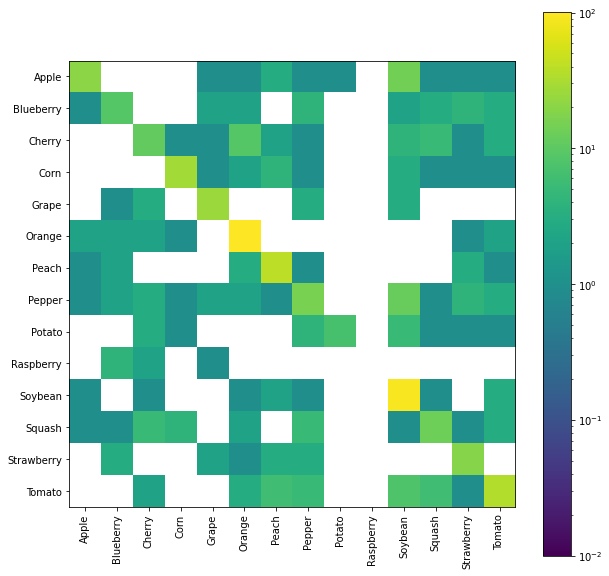

In [110]:
# --- TRAINING ---

from sklearn.svm import SVC

# define model inputs
X_train = np.array(hsv_flat_train)
#X_train = np.concatenate((hsv_flat_train, rgb_flat_train), axis=1)

y_train = np.array(labels_train_14)
X_train, y_train = shuffle(X_train, y_train, random_state=0)

X_test = np.array(hsv_flat_test)
#X_test = np.concatenate((hsv_flat_test, rgb_flat_test), axis=1) #, rgb_flat_test
y_test = np.array(labels_test_14)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

# train
model_svc = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='rbf', probability=True))
model_svc.fit(X_train, y_train)

# evaluation - baseline model
evaluation(model_svc, X_test, y_test)

In [114]:
# --- HYPERPARAMETER TUNING ---

# define model inputs
X_valid = np.array(hsv_flat_valid)
#X_valid = np.concatenate((hsv_flat_valid, rgb_flat_valid), axis=1) #, rgb_flat_valid
y_valid = np.array(labels_valid_14)
X_valid, y_valid = shuffle(X_valid, y_valid, random_state=0)

# hyperparameter tuning
para_C = (0.1, 1, 10, 100) # np.linspace(1,20,10) 
K = ('linear', 'poly', 'rbf')

ACC_validation = {}
for c in para_C:
    for item in K:
        #train
        model_svc = make_pipeline(StandardScaler(), SVC(gamma='auto', C = c, kernel=item, probability=True))
        model_svc.fit(X_train, y_train)

        #evaluate
        temp = 'c =' + str(c) + ',kernal=' + str(item) 
        ACC_validation[temp] = evaluation_report(model_svc, X_valid, y_valid)['accuracy']

ACC_validation

/opt/homebrew/Caskroom/miniforge/base/envs/aml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/aml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/aml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

{'c =0.1,kernal=linear': 0.6112224448897795,
 'c =0.1,kernal=poly': 0.3186372745490982,
 'c =0.1,kernal=rbf': 0.40981963927855714,
 'c =1,kernal=linear': 0.5881763527054108,
 'c =1,kernal=poly': 0.43887775551102204,
 'c =1,kernal=rbf': 0.6513026052104208,
 'c =10,kernal=linear': 0.5881763527054108,
 'c =10,kernal=poly': 0.5350701402805611,
 'c =10,kernal=rbf': 0.6973947895791583,
 'c =100,kernal=linear': 0.5881763527054108,
 'c =100,kernal=poly': 0.5821643286573146,
 'c =100,kernal=rbf': 0.6863727454909819}

              precision    recall  f1-score   support

       Apple       0.74      0.45      0.56        44
   Blueberry       0.50      0.33      0.40        30
      Cherry       0.50      0.47      0.49        38
        Corn       0.87      0.62      0.72        42
       Grape       0.74      0.80      0.77        35
      Orange       0.76      0.91      0.83       110
       Peach       0.71      0.71      0.71        52
      Pepper       0.32      0.42      0.36        48
      Potato       0.77      0.43      0.56        23
   Raspberry       0.50      0.29      0.36         7
     Soybean       0.71      0.85      0.77       101
      Squash       0.62      0.50      0.55        36
  Strawberry       0.58      0.71      0.64        31
      Tomato       0.63      0.59      0.61        66

    accuracy                           0.66       663
   macro avg       0.64      0.58      0.60       663
weighted avg       0.66      0.66      0.65       663



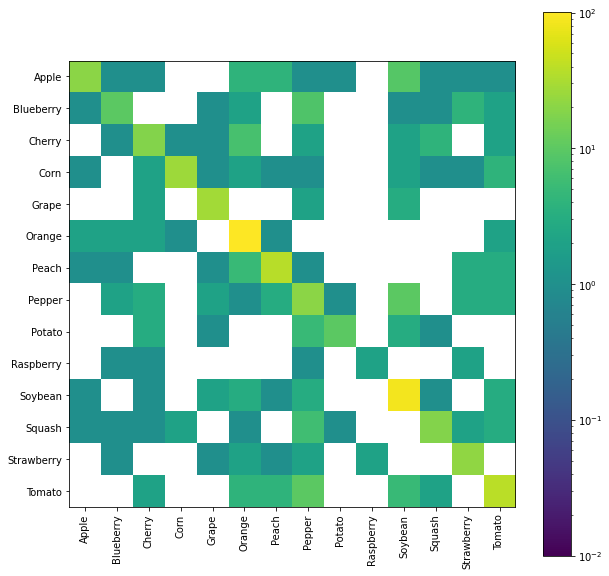

In [115]:
# --- PERFORMANCE ON TESTING DATASET ---

# train again with best parameter set
c = 10
kernel = 'rbf'
model_svc = make_pipeline(StandardScaler(), SVC(gamma='auto', C = c, kernel=kernel, probability=True))
model_svc.fit(X_train, y_train)

# evaluate - best model
evaluation(model_svc, X_test, y_test)

## CNN

In [55]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder

In [56]:
# --- MODEL STRUCTURE ---

n_classes = len(np.unique(y_train))

model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
# model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(n_classes*12, activation='relu'))
model_cnn.add(layers.Dense(n_classes, activation='relu'))

model_cnn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 168)               4

**Conv2D(filters, kernel_size, ...)**

No need to define filter channel because filter channel has to be equal to input channel.

**Output Shape(height, width, channel)**

It's a 3D tensor. Height & width depends on the filter size, the number of output channel is controlled by the first argument (how much filter you use).

Typically, as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

**Pooling**

Downsampling by aggregating numbers over the sliding window.

**Flatten**

Turn 3D tensor into a 1D array.

In [57]:
# --- define model inputs ---

X_train = edges_train
X_valid = edges_valid
X_test = edges_test

# transform string labels to integer labels
le = LabelEncoder()
le.fit(labels_train_14)
for i, k in enumerate(le.classes_):
    print(i, k)

y_train = le.transform(labels_train_14)
y_valid = le.transform(labels_valid_14)
y_test = le.transform(labels_test_14)

# shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_valid, y_valid = shuffle(X_valid, y_valid, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

0 Apple
1 Blueberry
2 Cherry
3 Corn
4 Grape
5 Orange
6 Peach
7 Pepper
8 Potato
9 Raspberry
10 Soybean
11 Squash
12 Strawberry
13 Tomato


In [70]:
# --- TRAINING ---
history = model_cnn.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
14/14 [==============================] - 51s 4s/step - loss: 2.2695 - accuracy: 0.2213 - val_loss: 2.3777 - val_accuracy: 0.2134
Epoch 2/10
14/14 [==============================] - 50s 4s/step - loss: 2.2297 - accuracy: 0.2303 - val_loss: 2.3603 - val_accuracy: 0.2174
Epoch 3/10
14/14 [==============================] - 49s 4s/step - loss: 2.1984 - accuracy: 0.2410 - val_loss: 2.3517 - val_accuracy: 0.2204
Epoch 4/10
14/14 [==============================] - 49s 4s/step - loss: 2.1790 - accuracy: 0.2494 - val_loss: 2.3435 - val_accuracy: 0.2395
Epoch 5/10
14/14 [==============================] - 50s 4s/step - loss: 2.1445 - accuracy: 0.2578 - val_loss: 2.3420 - val_accuracy: 0.2244
Epoch 6/10
14/14 [==============================] - 54s 4s/step - loss: 2.1161 - accuracy: 0.2638 - val_loss: 2.3293 - val_accuracy: 0.2415
Epoch 7/10
14/14 [==============================] - 49s 3s/step - loss: 2.0987 - accuracy: 0.2679 - val_loss: 2.3303 - val_accuracy: 0.2375
Epoch 8/10
14/14 [==

21/21 [==============================] - 3s 150ms/step - loss: 2.3468 - accuracy: 0.2428


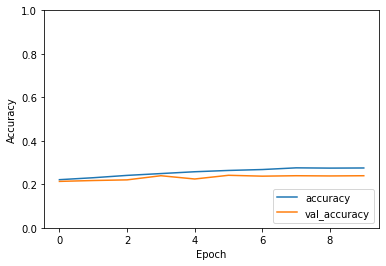

In [71]:
# --- EVALUATION ---
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model_cnn.evaluate(X_test, y_test)

# Classification: 4 Health Conditions of Corn Leaves

### Dataset Preparation

In [99]:
### sample images for the classification problem (ONLY RUN ONCE)
# before running, delete everything in the dst_dir

os.getcwd()
os.chdir("/Users/catherineyu/Plant")

sample_pct = np.array([0.3, 0.1, 0.1])  # train/validation/valid
src_dir = "/Users/catherineyu/Plant/Plant_dataset"
dst_dir = "/Users/catherineyu/Plant/Plant_dataset_sample2"

# create path
train_dir = os.path.join(dst_dir, "train")
valid_dir = os.path.join(dst_dir, "valid")
test_dir = os.path.join(dst_dir, "test")
os.makedirs(train_dir)
os.makedirs(valid_dir)
os.makedirs(test_dir)

# define category list
category_list = ["Corn___Cercospora_leaf_spot Gray_leaf_spot", "Corn___Common_rust", "Corn___Northern_Leaf_Blight", "Corn___healthy"]

for cat in category_list:
    
    # create path
    src_cat_dir = os.path.join(src_dir, cat)
    train_cat_dir = os.path.join(train_dir, cat)
    valid_cat_dir = os.path.join(valid_dir, cat)
    test_cat_dir = os.path.join(test_dir, cat)
    os.makedirs(train_cat_dir)
    os.makedirs(valid_cat_dir)
    os.makedirs(test_cat_dir)   

    # determine sample counts
    total_cnt = len(os.listdir(src_cat_dir))
    sample_cnt = [math.floor(i) for i in sample_pct * total_cnt]
    print(cat, "sampled count:", sample_cnt)

    # random draw without replacement
    random.seed(1)
    total_im_list = list(range(1, total_cnt))
    sample_im_list = random.sample(total_im_list, sum(sample_cnt))

    # copy images
    train_cnt, valid_cnt, test_cnt = sample_cnt[0], sample_cnt[1], sample_cnt[2]
    for im in sample_im_list[0:train_cnt]:
        img_name = 'image ({}).JPG'.format(im)
        shutil.copy(os.path.join(src_dir, cat, img_name), train_cat_dir)
    
    for im in sample_im_list[train_cnt:(train_cnt+valid_cnt)]:
        img_name = 'image ({}).JPG'.format(im)
        shutil.copy(os.path.join(src_dir, cat, img_name), valid_cat_dir)
    
    for im in sample_im_list[(train_cnt+valid_cnt):]:
        img_name = 'image ({}).JPG'.format(im)
        shutil.copy(os.path.join(src_dir, cat, img_name), test_cat_dir)

Corn___Cercospora_leaf_spot Gray_leaf_spot sampled count: [153, 51, 51]
Corn___Common_rust sampled count: [357, 119, 119]
Corn___Northern_Leaf_Blight sampled count: [295, 98, 98]
Corn___healthy sampled count: [348, 116, 116]


In [100]:
# --- init path settings ---

dst_dir2 = "/Users/catherineyu/Plant/Plant_dataset_sample2"
train_dir = os.path.join(dst_dir2, "train")
valid_dir = os.path.join(dst_dir2, "valid")
test_dir = os.path.join(dst_dir2, "test")

# define category list
category_list = ["Corn___Cercospora_leaf_spot Gray_leaf_spot", "Corn___Common_rust", "Corn___Northern_Leaf_Blight", "Corn___healthy"]

# --- Helper Functions and global objects ---

def load_image_from_folder_2(dataset):
    """
    Return images and labels under certain folder as numpy arrays.
    `dataset`: train / valid / test
    """
    images = []
    labels = []
    ds_dir = os.path.join(dst_dir2, dataset)

    for cat in category_list:
        ds_cat_dir = os.path.join(ds_dir, cat)
        
        # load images
        images_cat = []
        for im_name in glob.glob(ds_cat_dir+'/*.JPG'):
            im = Image.open(im_name) 
            im = im.resize((256, 256)) # 90% images in our dataset are size (256, 256)
            # im = plt.imread(im_name)
            images_cat.append(im)

        # read labels
        labels_cat = [cat] * len(images_cat)
    
        images.extend(images_cat)
        labels.extend(labels_cat)

    return images, labels

<class 'PIL.Image.Image'>
Corn___Cercospora_leaf_spot Gray_leaf_spot


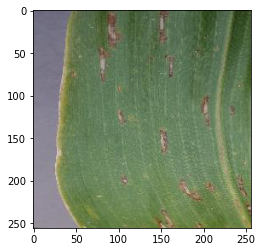

In [101]:
# --- load data ---

# read images(X), labels (Y) and create object
images_corn_train, labels_corn_train = load_image_from_folder_2("train")
images_corn_valid, labels_corn_valid = load_image_from_folder_2("valid")
images_corn_test, labels_corn_test = load_image_from_folder_2("test")

# sanity check
print(type(images_corn_train[0]))
print(labels_corn_train[0])
plt.imshow(images_corn_train[0])

In [102]:
# feature pipeline

#hsv
hsv_corn_train = get_feature_cropped_hsv_histogram(images_corn_train)
hsv_corn_flat_train = hsv_corn_train.reshape(hsv_corn_train.shape[0], 3*256) # (3 * 256): 3 channels * 256 histomgram bins

hsv_corn_valid = get_feature_cropped_hsv_histogram(images_corn_valid)
hsv_corn_flat_valid = hsv_corn_valid.reshape(hsv_corn_valid.shape[0], 3*256) # (3 * 256): 3 channels * 256 histomgram bins

hsv_corn_test = get_feature_cropped_hsv_histogram(images_corn_test)
hsv_corn_flat_test = hsv_corn_test.reshape(hsv_corn_test.shape[0], 3*256) # (3 * 256): 3 channels * 256 histomgram bins

#rgb
rgb_corn_train = get_feature_cropped_rgb_histogram(images_corn_train)
rgb_corn_flat_train = rgb_corn_train.reshape(rgb_corn_train.shape[0], 3*256) # (3 * 256): 3 channels * 256 histomgram bins

rgb_corn_test = get_feature_cropped_rgb_histogram(images_corn_test)
rgb_corn_flat_test = rgb_corn_test.reshape(rgb_corn_test.shape[0], 3*256) # (3 * 256): 3 channels * 256 histomgram bins

rgb_corn_valid = get_feature_cropped_rgb_histogram(images_corn_valid)
rgb_corn_flat_valid = rgb_corn_valid.reshape(rgb_corn_valid.shape[0], 3*256)

## Non-linear SVM

                                            precision    recall  f1-score   support

Corn___Cercospora_leaf_spot Gray_leaf_spot       0.56      0.37      0.45        51
                        Corn___Common_rust       0.86      0.88      0.87       119
               Corn___Northern_Leaf_Blight       0.70      0.72      0.71        98
                            Corn___healthy       0.91      0.99      0.95       116

                                  accuracy                           0.81       384
                                 macro avg       0.76      0.74      0.74       384
                              weighted avg       0.79      0.81      0.80       384



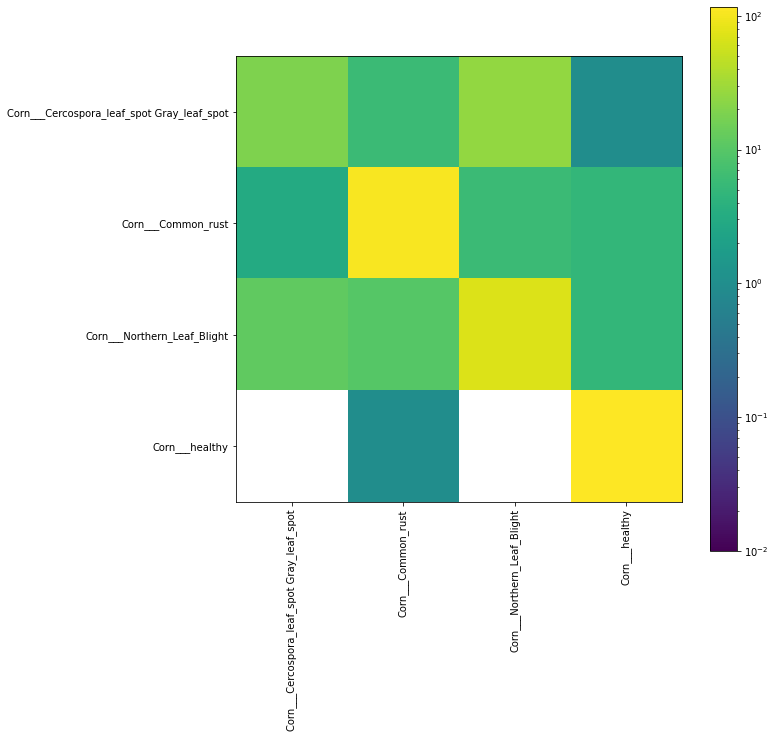

In [116]:
# --- TRAINING ---

from sklearn.svm import SVC

# define model inputs
X_train = np.array(hsv_corn_flat_train)
#X_train = np.concatenate((hsv_corn_flat_train, rgb_corn_flat_train), axis=1)

y_train = np.array(labels_corn_train)
X_train, y_train = shuffle(X_train, y_train, random_state=0)

X_test = np.array(hsv_corn_flat_test)
#X_test = np.concatenate((hsv_corn_flat_test, rgb_corn_flat_test), axis=1)
y_test = np.array(labels_corn_test)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

# train
model_svc = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='rbf', probability=True))
model_svc.fit(X_train, y_train)

# evaluation - baseline model
evaluation(model_svc, X_test, y_test)

In [117]:
# --- HYPERPARAMETER TUNING ---

# define model inputs
X_valid = np.array(hsv_corn_flat_valid)
#X_valid = np.concatenate((hsv_corn_flat_valid, rgb_corn_flat_valid), axis=1)
y_valid = np.array(labels_corn_valid)
X_valid, y_valid = shuffle(X_valid, y_valid, random_state=0)

# hyperparameter tuning
para_C = (0.1, 1, 10, 100) # np.linspace(1,20,10) 
K = ('linear', 'poly', 'rbf')

ACC_validation = {}
for c in para_C:
    for item in K:
        #train
        model_svc = make_pipeline(StandardScaler(), SVC(gamma='auto', C = c, kernel=item, probability=True))
        model_svc.fit(X_train, y_train)

        #evaluate
        temp = 'c =' + str(c) + ',kernal=' + str(item) 
        ACC_validation[temp] = evaluation_report(model_svc, X_valid, y_valid)['accuracy']

ACC_validation

/opt/homebrew/Caskroom/miniforge/base/envs/aml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/aml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/aml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

{'c =0.1,kernal=linear': 0.8255208333333334,
 'c =0.1,kernal=poly': 0.4921875,
 'c =0.1,kernal=rbf': 0.7526041666666666,
 'c =1,kernal=linear': 0.796875,
 'c =1,kernal=poly': 0.6927083333333334,
 'c =1,kernal=rbf': 0.8046875,
 'c =10,kernal=linear': 0.796875,
 'c =10,kernal=poly': 0.7942708333333334,
 'c =10,kernal=rbf': 0.8229166666666666,
 'c =100,kernal=linear': 0.796875,
 'c =100,kernal=poly': 0.8229166666666666,
 'c =100,kernal=rbf': 0.8177083333333334}

                                            precision    recall  f1-score   support

Corn___Cercospora_leaf_spot Gray_leaf_spot       0.56      0.37      0.45        51
                        Corn___Common_rust       0.86      0.88      0.87       119
               Corn___Northern_Leaf_Blight       0.70      0.72      0.71        98
                            Corn___healthy       0.91      0.99      0.95       116

                                  accuracy                           0.81       384
                                 macro avg       0.76      0.74      0.74       384
                              weighted avg       0.79      0.81      0.80       384



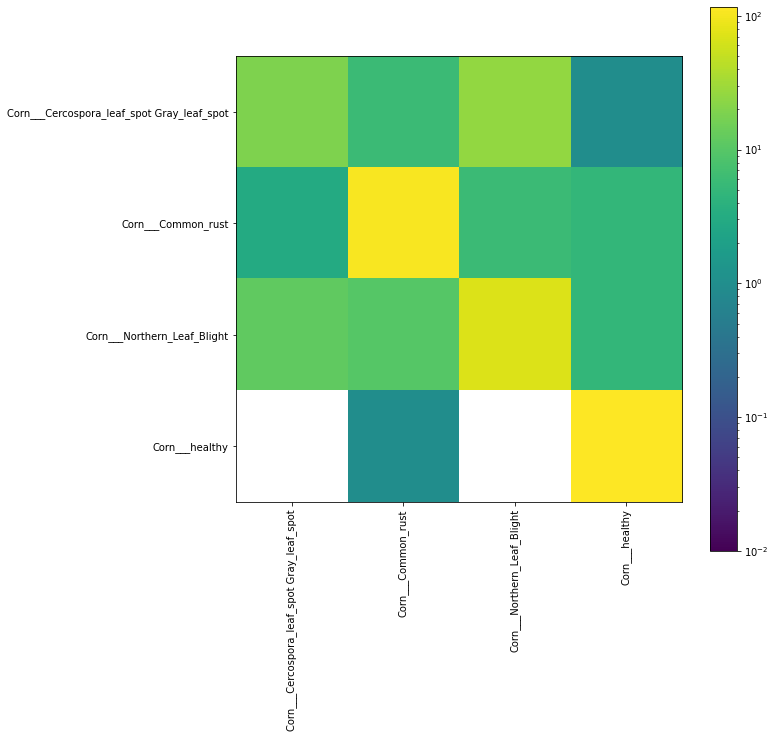

In [118]:
# --- PERFORMANCE ON TESTING DATASET ---

# train again with best parameter set
c = 1
kernel = 'rbf'
model_svc = make_pipeline(StandardScaler(), SVC(gamma='auto', C = c, kernel=kernel, probability=True))
model_svc.fit(X_train, y_train)

# evaluate - best model
evaluation(model_svc, X_test, y_test)

## Logistic Regression (SKIPPED FOR NOW)

In [159]:
from sklearn.linear_model import LogisticRegression

# train
model_lr = make_pipeline(StandardScaler(), LogisticRegression(
    random_state=0,
    class_weight="balanced",
    solver="saga",
    max_iter=500
    # multi_class="multinomial"
    ))
model_lr.fit(X_train, y_train)

/Users/heidi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=500,
                                    random_state=0, solver='saga'))])

In [ ]:
# Feature Extraction (build pipelines)
### apply filters - 1
### apply filters - 2
### valid and test data transform (if needed)

# Classification
### shuffle images and labels
### fit classifiers
### inference on valid data
### model tuning

# Generalizability
### inference on test data
### analysis on generalizability & classifier performance

# Contributions

# Contributions
- Heidi: data sampling, feature extraction (colors, texture), classification(CNN, SVM)
- Catherine: feature extraction (edges, veins, intensity), classification(SVM)